<a href="https://colab.research.google.com/github/Bhanusree7/Lung-Cancer-Prediction-Using-Ensemble-Learning/blob/main/Lung_Cancer_Prediction_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install split-folders


In [ ]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from IPython.display import Image
import tensorflow.keras.backend as K
import splitfolders
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
print(os.getcwd(), os.listdir())
DIR = '/content/drive/MyDrive/lung-cancer-detection-main/lung-cancer-detection-main/rawData'
CATS = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

DEST_DIR = './data'

/content ['.config', 'drive', 'sample_data']


In [ ]:
BATCH_SIZE=32


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2,
                                                                rotation_range=5,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest'
                                                                )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/lung-cancer-detection-main/lung-cancer-detection-main/processedData/train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 32)

Found 699 images belonging to 2 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/lung-cancer-detection-main/lung-cancer-detection-main/processedData/val',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 99 images belonging to 2 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/lung-cancer-detection-main/lung-cancer-detection-main/processedData/test',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 202 images belonging to 2 classes.


In [ ]:
def F1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),
      tf.keras.metrics.AUC(name='AUC'),
      F1,
]

def plot_history(hist, name):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].plot(hist.history['Accuracy'])
  axs[0].plot(hist.history['val_Accuracy'])
  axs[0].set_title(f'{name} Accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['train', 'val', 'F1', 'Recall'], loc='upper left')

  axs[1].plot(hist.history['loss'])
  axs[1].plot(hist.history['val_loss'])
  axs[1].set_title(f'{name} Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['train', 'val'], loc='upper left')

  axs[2].plot(hist.history['Precision'])
  axs[2].plot(hist.history['val_Precision'])
  axs[2].set_title(f'{name} Precision')
  axs[2].set_ylabel('Precision')
  axs[2].set_xlabel('Epoch')
  axs[2].legend(['train', 'val'], loc='upper left')

  plt.show()


CNN


In [ ]:
CNN = tf.keras.Sequential()
CNN.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
CNN.add(tf.keras.layers.Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Flatten())
CNN.add(tf.keras.layers.Dense(units=64, activation='relu'))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

CNN.summary()

CNN.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 110, 110, 36)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 128)      

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('CNN.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

CNN_history = CNN.fit(train_dataset,validation_data=valid_dataset, epochs = 36,verbose = 1, callbacks=[lrd,mcp,es], shuffle=True)


Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.5801 - Accuracy: 0.7725 - Precision: 0.1538 - Recall: 0.0133 - AUC: 0.5501 - F1: 0.0202

22/22 [==============================] - 28s 1s/step - loss: 0.5801 - Accuracy: 0.7725 - Precision: 0.1538 - Recall: 0.0133 - AUC: 0.5501 - F1: 0.0202 - val_loss: 0.5877 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.8049 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.4938 - Accuracy: 0.7854 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.6656 - F1: 0.0000e+00

22/22 [==============================] - 12s 544ms/step - loss: 0.4938 - Accuracy: 0.7854 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.6656 - F1: 0.0000e+00 - val_loss: 0.3687 - val_Accuracy: 0.8081 - val_Precision: 1.0000 - val_Recall: 0.0952 - val_AUC: 0.8858 - val_F1: 0.1181 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4153 - Accuracy: 0.8155 - Precision: 0.7333 - Recall: 0.2200 - AUC: 0.8025 - F1: 0.2925

22/22 [==============================] - 12s 550ms/step - loss: 0.4153 - Accuracy: 0.8155 - Precision: 0.7333 - Recall: 0.2200 - AUC: 0.8025 - F1: 0.2925 - val_loss: 0.2915 - val_Accuracy: 0.9293 - val_Precision: 0.8182 - val_Recall: 0.8571 - val_AUC: 0.9487 - val_F1: 0.8603 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.3677 - Accuracy: 0.8469 - Precision: 0.7416 - Recall: 0.4400 - AUC: 0.8536 - F1: 0.5435

22/22 [==============================] - 12s 564ms/step - loss: 0.3677 - Accuracy: 0.8469 - Precision: 0.7416 - Recall: 0.4400 - AUC: 0.8536 - F1: 0.5435 - val_loss: 0.3520 - val_Accuracy: 0.8081 - val_Precision: 0.5250 - val_Recall: 1.0000 - val_AUC: 0.9744 - val_F1: 0.5160 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.3146 - Accuracy: 0.8770 - Precision: 0.7963 - Recall: 0.5733 - AUC: 0.8982 - F1: 0.6369

22/22 [==============================] - 12s 526ms/step - loss: 0.3146 - Accuracy: 0.8770 - Precision: 0.7963 - Recall: 0.5733 - AUC: 0.8982 - F1: 0.6369 - val_loss: 0.2693 - val_Accuracy: 0.8586 - val_Precision: 0.6000 - val_Recall: 1.0000 - val_AUC: 0.9832 - val_F1: 0.8035 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.2744 - Accuracy: 0.9027 - Precision: 0.8475 - Recall: 0.6667 - AUC: 0.9211 - F1: 0.7323

22/22 [==============================] - 11s 482ms/step - loss: 0.2744 - Accuracy: 0.9027 - Precision: 0.8475 - Recall: 0.6667 - AUC: 0.9211 - F1: 0.7323 - val_loss: 0.3118 - val_Accuracy: 0.8586 - val_Precision: 0.6000 - val_Recall: 1.0000 - val_AUC: 0.9896 - val_F1: 0.7970 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.3141 - Accuracy: 0.8755 - Precision: 0.7944 - Recall: 0.5667 - AUC: 0.8929 - F1: 0.6361

22/22 [==============================] - 12s 548ms/step - loss: 0.3141 - Accuracy: 0.8755 - Precision: 0.7944 - Recall: 0.5667 - AUC: 0.8929 - F1: 0.6361 - val_loss: 0.2240 - val_Accuracy: 0.8990 - val_Precision: 1.0000 - val_Recall: 0.5238 - val_AUC: 0.9765 - val_F1: 0.5042 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.2886 - Accuracy: 0.8712 - Precision: 0.7941 - Recall: 0.5400 - AUC: 0.9159 - F1: 0.5742

22/22 [==============================] - 13s 606ms/step - loss: 0.2886 - Accuracy: 0.8712 - Precision: 0.7941 - Recall: 0.5400 - AUC: 0.9159 - F1: 0.5742 - val_loss: 0.2912 - val_Accuracy: 0.8283 - val_Precision: 0.5526 - val_Recall: 1.0000 - val_AUC: 0.9792 - val_F1: 0.5312 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.2444 - Accuracy: 0.8999 - Precision: 0.8704 - Recall: 0.6267 - AUC: 0.9450 - F1: 0.6787

22/22 [==============================] - 12s 547ms/step - loss: 0.2444 - Accuracy: 0.8999 - Precision: 0.8704 - Recall: 0.6267 - AUC: 0.9450 - F1: 0.6787 - val_loss: 0.2462 - val_Accuracy: 0.9192 - val_Precision: 0.7241 - val_Recall: 1.0000 - val_AUC: 0.9817 - val_F1: 0.6268 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.2139 - Accuracy: 0.9142 - Precision: 0.8516 - Recall: 0.7267 - AUC: 0.9556 - F1: 0.7826
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 12s 545ms/step - loss: 0.2139 - Accuracy: 0.9142 - Precision: 0.8516 - Recall: 0.7267 - AUC: 0.9556 - F1: 0.7826 - val_loss: 0.3343 - val_Accuracy: 0.8283 - val_Precision: 0.5526 - val_Recall: 1.0000 - val_AUC: 0.9802 - val_F1: 0.5275 - lr: 0.0010
Epoch 10: early stopping


In [ ]:
CNN_scores = CNN.evaluate(test_dataset, verbose=1)
print(f'Test Loss: {test_scores[0]:.4f}')
print(f'Test Accuracy: {test_scores[1]*100:.2f}%')

7/7 [==============================] - 1s 107ms/step - loss: 0.3137 - Accuracy: 0.8762 - Precision: 0.6377 - Recall: 1.0000 - AUC: 0.9827 - F1: 0.7803
Test Loss: 0.0336
Test Accuracy: 99.50%


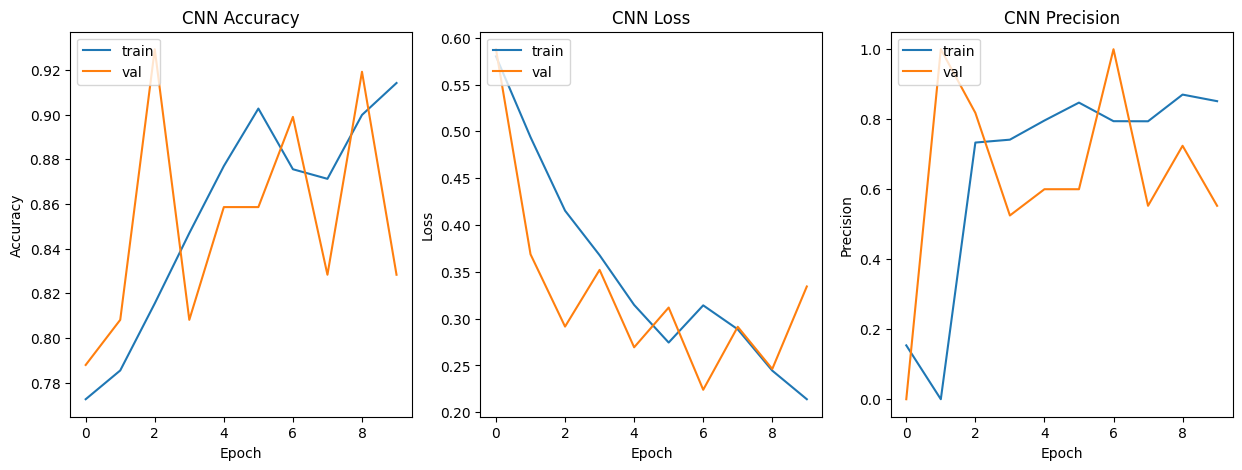

In [ ]:
plot_history(CNN_history, 'CNN')

VGG16

In [ ]:
VGG16_base = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in VGG16_base.layers:
    layer.trainable = False

VGG16=tf.keras.Sequential()
VGG16.add(VGG16_base)
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Flatten())
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dense(1,activation='sigmoid'))

VGG16.summary()

VGG16.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_4 (Bat  (None, 25088)             100352    
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 32)                802848    
                                                                 
 batch_normalization_5 (Bat  (None, 32)                128       
 chNormalization)                                     

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('VGG16.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

VGG16_history = VGG16.fit(train_dataset,validation_data=valid_dataset, epochs = 36, callbacks=[lrd,mcp,es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.5865 - Accuracy: 0.7492 - Precision: 0.4111 - Recall: 0.3814 - AUC: 0.7038 - F1: 0.2170

22/22 [==============================] - 26s 975ms/step - loss: 0.5865 - Accuracy: 0.7492 - Precision: 0.4111 - Recall: 0.3814 - AUC: 0.7038 - F1: 0.2170 - val_loss: 0.5686 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.8217 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.5029 - Accuracy: 0.7754 - Precision: 0.4533 - Recall: 0.2267 - AUC: 0.7081 - F1: 0.2950

22/22 [==============================] - 12s 562ms/step - loss: 0.5029 - Accuracy: 0.7754 - Precision: 0.4533 - Recall: 0.2267 - AUC: 0.7081 - F1: 0.2950 - val_loss: 0.3589 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.9924 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4284 - Accuracy: 0.8226 - Precision: 0.7241 - Recall: 0.2800 - AUC: 0.8126 - F1: 0.3873

22/22 [==============================] - 12s 565ms/step - loss: 0.4284 - Accuracy: 0.8226 - Precision: 0.7241 - Recall: 0.2800 - AUC: 0.8126 - F1: 0.3873 - val_loss: 0.3137 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.9988 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.4023 - Accuracy: 0.8455 - Precision: 0.8088 - Recall: 0.3667 - AUC: 0.8341 - F1: 0.5062

22/22 [==============================] - 12s 565ms/step - loss: 0.4023 - Accuracy: 0.8455 - Precision: 0.8088 - Recall: 0.3667 - AUC: 0.8341 - F1: 0.5062 - val_loss: 0.2508 - val_Accuracy: 0.8586 - val_Precision: 1.0000 - val_Recall: 0.3333 - val_AUC: 0.9994 - val_F1: 0.5808 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.3851 - Accuracy: 0.8412 - Precision: 0.7468 - Recall: 0.3933 - AUC: 0.8527 - F1: 0.5129

22/22 [==============================] - 13s 576ms/step - loss: 0.3851 - Accuracy: 0.8412 - Precision: 0.7468 - Recall: 0.3933 - AUC: 0.8527 - F1: 0.5129 - val_loss: 0.2303 - val_Accuracy: 0.8687 - val_Precision: 1.0000 - val_Recall: 0.3810 - val_AUC: 0.9982 - val_F1: 0.4111 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.3474 - Accuracy: 0.8569 - Precision: 0.7841 - Recall: 0.4600 - AUC: 0.8817 - F1: 0.5454

22/22 [==============================] - 14s 653ms/step - loss: 0.3474 - Accuracy: 0.8569 - Precision: 0.7841 - Recall: 0.4600 - AUC: 0.8817 - F1: 0.5454 - val_loss: 0.2327 - val_Accuracy: 0.8889 - val_Precision: 1.0000 - val_Recall: 0.4762 - val_AUC: 0.9963 - val_F1: 0.7163 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.3141 - Accuracy: 0.8813 - Precision: 0.8317 - Recall: 0.5600 - AUC: 0.9101 - F1: 0.6680

22/22 [==============================] - 13s 567ms/step - loss: 0.3141 - Accuracy: 0.8813 - Precision: 0.8317 - Recall: 0.5600 - AUC: 0.9101 - F1: 0.6680 - val_loss: 0.1867 - val_Accuracy: 0.9192 - val_Precision: 1.0000 - val_Recall: 0.6190 - val_AUC: 0.9982 - val_F1: 0.4000 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.3105 - Accuracy: 0.8841 - Precision: 0.8557 - Recall: 0.5533 - AUC: 0.9185 - F1: 0.6721

22/22 [==============================] - 12s 562ms/step - loss: 0.3105 - Accuracy: 0.8841 - Precision: 0.8557 - Recall: 0.5533 - AUC: 0.9185 - F1: 0.6721 - val_loss: 0.1748 - val_Accuracy: 0.9293 - val_Precision: 1.0000 - val_Recall: 0.6667 - val_AUC: 0.9994 - val_F1: 0.5944 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.2768 - Accuracy: 0.8898 - Precision: 0.8230 - Recall: 0.6200 - AUC: 0.9341 - F1: 0.6907

22/22 [==============================] - 13s 579ms/step - loss: 0.2768 - Accuracy: 0.8898 - Precision: 0.8230 - Recall: 0.6200 - AUC: 0.9341 - F1: 0.6907 - val_loss: 0.1561 - val_Accuracy: 0.9394 - val_Precision: 1.0000 - val_Recall: 0.7143 - val_AUC: 0.9966 - val_F1: 0.8423 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.2572 - Accuracy: 0.9084 - Precision: 0.9135 - Recall: 0.6333 - AUC: 0.9407 - F1: 0.7512

22/22 [==============================] - 13s 577ms/step - loss: 0.2572 - Accuracy: 0.9084 - Precision: 0.9135 - Recall: 0.6333 - AUC: 0.9407 - F1: 0.7512 - val_loss: 0.1555 - val_Accuracy: 0.9293 - val_Precision: 1.0000 - val_Recall: 0.6667 - val_AUC: 0.9963 - val_F1: 0.6122 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.2447 - Accuracy: 0.8956 - Precision: 0.8291 - Recall: 0.6467 - AUC: 0.9506 - F1: 0.7180

22/22 [==============================] - 12s 534ms/step - loss: 0.2447 - Accuracy: 0.8956 - Precision: 0.8291 - Recall: 0.6467 - AUC: 0.9506 - F1: 0.7180 - val_loss: 0.1295 - val_Accuracy: 0.9293 - val_Precision: 1.0000 - val_Recall: 0.6667 - val_AUC: 0.9939 - val_F1: 0.8423 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.2353 - Accuracy: 0.9185 - Precision: 0.8720 - Recall: 0.7267 - AUC: 0.9523 - F1: 0.7846

22/22 [==============================] - 12s 529ms/step - loss: 0.2353 - Accuracy: 0.9185 - Precision: 0.8720 - Recall: 0.7267 - AUC: 0.9523 - F1: 0.7846 - val_loss: 0.1382 - val_Accuracy: 0.9394 - val_Precision: 1.0000 - val_Recall: 0.7143 - val_AUC: 0.9911 - val_F1: 0.6626 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.2710 - Accuracy: 0.8970 - Precision: 0.8095 - Recall: 0.6800 - AUC: 0.9294 - F1: 0.7257

22/22 [==============================] - 12s 552ms/step - loss: 0.2710 - Accuracy: 0.8970 - Precision: 0.8095 - Recall: 0.6800 - AUC: 0.9294 - F1: 0.7257 - val_loss: 0.1174 - val_Accuracy: 0.9798 - val_Precision: 1.0000 - val_Recall: 0.9048 - val_AUC: 0.9875 - val_F1: 0.8939 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.2475 - Accuracy: 0.8956 - Precision: 0.8031 - Recall: 0.6800 - AUC: 0.9467 - F1: 0.7255

22/22 [==============================] - 13s 568ms/step - loss: 0.2475 - Accuracy: 0.8956 - Precision: 0.8031 - Recall: 0.6800 - AUC: 0.9467 - F1: 0.7255 - val_loss: 0.1095 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9841 - val_F1: 0.9833 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.2082 - Accuracy: 0.9185 - Precision: 0.8496 - Recall: 0.7533 - AUC: 0.9617 - F1: 0.7986

22/22 [==============================] - 13s 578ms/step - loss: 0.2082 - Accuracy: 0.9185 - Precision: 0.8496 - Recall: 0.7533 - AUC: 0.9617 - F1: 0.7986 - val_loss: 0.1097 - val_Accuracy: 0.9697 - val_Precision: 1.0000 - val_Recall: 0.8571 - val_AUC: 0.9893 - val_F1: 0.6706 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.2054 - Accuracy: 0.9142 - Precision: 0.8689 - Recall: 0.7067 - AUC: 0.9619 - F1: 0.7874

22/22 [==============================] - 12s 566ms/step - loss: 0.2054 - Accuracy: 0.9142 - Precision: 0.8689 - Recall: 0.7067 - AUC: 0.9619 - F1: 0.7874 - val_loss: 0.1083 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9847 - val_F1: 0.9808 - lr: 0.0010
Epoch 17/36
22/22 [==============================] - ETA: 0s - loss: 0.2136 - Accuracy: 0.9270 - Precision: 0.8722 - Recall: 0.7733 - AUC: 0.9538 - F1: 0.8127

22/22 [==============================] - 12s 557ms/step - loss: 0.2136 - Accuracy: 0.9270 - Precision: 0.8722 - Recall: 0.7733 - AUC: 0.9538 - F1: 0.8127 - val_loss: 0.1057 - val_Accuracy: 0.9596 - val_Precision: 1.0000 - val_Recall: 0.8095 - val_AUC: 0.9875 - val_F1: 0.9143 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - ETA: 0s - loss: 0.1874 - Accuracy: 0.9385 - Precision: 0.9084 - Recall: 0.7933 - AUC: 0.9655 - F1: 0.8397

22/22 [==============================] - 12s 564ms/step - loss: 0.1874 - Accuracy: 0.9385 - Precision: 0.9084 - Recall: 0.7933 - AUC: 0.9655 - F1: 0.8397 - val_loss: 0.0954 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9869 - val_F1: 0.9773 - lr: 0.0010
Epoch 19/36
22/22 [==============================] - ETA: 0s - loss: 0.1992 - Accuracy: 0.9285 - Precision: 0.8425 - Recall: 0.8200 - AUC: 0.9675 - F1: 0.8235

22/22 [==============================] - 12s 561ms/step - loss: 0.1992 - Accuracy: 0.9285 - Precision: 0.8425 - Recall: 0.8200 - AUC: 0.9675 - F1: 0.8235 - val_loss: 0.0855 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9878 - val_F1: 0.7353 - lr: 0.0010
Epoch 20/36
22/22 [==============================] - ETA: 0s - loss: 0.1789 - Accuracy: 0.9242 - Precision: 0.8392 - Recall: 0.8000 - AUC: 0.9725 - F1: 0.8160

22/22 [==============================] - 12s 564ms/step - loss: 0.1789 - Accuracy: 0.9242 - Precision: 0.8392 - Recall: 0.8000 - AUC: 0.9725 - F1: 0.8160 - val_loss: 0.0951 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9872 - val_F1: 0.9591 - lr: 0.0010
Epoch 21/36
22/22 [==============================] - ETA: 0s - loss: 0.1720 - Accuracy: 0.9385 - Precision: 0.8690 - Recall: 0.8400 - AUC: 0.9764 - F1: 0.8464

22/22 [==============================] - 12s 570ms/step - loss: 0.1720 - Accuracy: 0.9385 - Precision: 0.8690 - Recall: 0.8400 - AUC: 0.9764 - F1: 0.8464 - val_loss: 0.0846 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9860 - val_F1: 0.9583 - lr: 0.0010
Epoch 22/36
22/22 [==============================] - ETA: 0s - loss: 0.1849 - Accuracy: 0.9342 - Precision: 0.8768 - Recall: 0.8067 - AUC: 0.9715 - F1: 0.8269

22/22 [==============================] - 12s 567ms/step - loss: 0.1849 - Accuracy: 0.9342 - Precision: 0.8768 - Recall: 0.8067 - AUC: 0.9715 - F1: 0.8269 - val_loss: 0.0949 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9841 - val_F1: 0.7161 - lr: 0.0010
Epoch 23/36
22/22 [==============================] - ETA: 0s - loss: 0.1806 - Accuracy: 0.9299 - Precision: 0.8633 - Recall: 0.8000 - AUC: 0.9675 - F1: 0.8195

22/22 [==============================] - 13s 573ms/step - loss: 0.1806 - Accuracy: 0.9299 - Precision: 0.8633 - Recall: 0.8000 - AUC: 0.9675 - F1: 0.8195 - val_loss: 0.0814 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9857 - val_F1: 0.9606 - lr: 0.0010
Epoch 24/36
22/22 [==============================] - ETA: 0s - loss: 0.1920 - Accuracy: 0.9270 - Precision: 0.8462 - Recall: 0.8067 - AUC: 0.9645 - F1: 0.8113

22/22 [==============================] - 13s 572ms/step - loss: 0.1920 - Accuracy: 0.9270 - Precision: 0.8462 - Recall: 0.8067 - AUC: 0.9645 - F1: 0.8113 - val_loss: 0.0754 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9872 - val_F1: 0.9615 - lr: 0.0010
Epoch 25/36
22/22 [==============================] - ETA: 0s - loss: 0.1598 - Accuracy: 0.9356 - Precision: 0.8723 - Recall: 0.8200 - AUC: 0.9779 - F1: 0.8453

22/22 [==============================] - 13s 567ms/step - loss: 0.1598 - Accuracy: 0.9356 - Precision: 0.8723 - Recall: 0.8200 - AUC: 0.9779 - F1: 0.8453 - val_loss: 0.0781 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9893 - val_F1: 0.7222 - lr: 0.0010
Epoch 26/36
22/22 [==============================] - ETA: 0s - loss: 0.1701 - Accuracy: 0.9356 - Precision: 0.8889 - Recall: 0.8000 - AUC: 0.9728 - F1: 0.8248

22/22 [==============================] - ETA: 0s - loss: 0.1586 - Accuracy: 0.9356 - Precision: 0.8723 - Recall: 0.8200 - AUC: 0.9773 - F1: 0.8367

22/22 [==============================] - 12s 564ms/step - loss: 0.1586 - Accuracy: 0.9356 - Precision: 0.8723 - Recall: 0.8200 - AUC: 0.9773 - F1: 0.8367 - val_loss: 0.0709 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9896 - val_F1: 0.9853 - lr: 0.0010
Epoch 28/36
22/22 [==============================] - ETA: 0s - loss: 0.1614 - Accuracy: 0.9428 - Precision: 0.8618 - Recall: 0.8733 - AUC: 0.9758 - F1: 0.8614

22/22 [==============================] - 12s 564ms/step - loss: 0.1614 - Accuracy: 0.9428 - Precision: 0.8618 - Recall: 0.8733 - AUC: 0.9758 - F1: 0.8614 - val_loss: 0.0670 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9908 - val_F1: 0.9167 - lr: 0.0010
Epoch 29/36
22/22 [==============================] - ETA: 0s - loss: 0.1631 - Accuracy: 0.9342 - Precision: 0.8768 - Recall: 0.8067 - AUC: 0.9745 - F1: 0.8353

22/22 [==============================] - 13s 567ms/step - loss: 0.1631 - Accuracy: 0.9342 - Precision: 0.8768 - Recall: 0.8067 - AUC: 0.9745 - F1: 0.8353 - val_loss: 0.0608 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9939 - val_F1: 0.9853 - lr: 0.0010
Epoch 30/36
22/22 [==============================] - ETA: 0s - loss: 0.1698 - Accuracy: 0.9313 - Precision: 0.8493 - Recall: 0.8267 - AUC: 0.9759 - F1: 0.8371

22/22 [==============================] - 12s 517ms/step - loss: 0.1698 - Accuracy: 0.9313 - Precision: 0.8493 - Recall: 0.8267 - AUC: 0.9759 - F1: 0.8371 - val_loss: 0.0618 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9924 - val_F1: 0.7333 - lr: 0.0010
Epoch 31/36
22/22 [==============================] - ETA: 0s - loss: 0.1640 - Accuracy: 0.9356 - Precision: 0.8671 - Recall: 0.8267 - AUC: 0.9756 - F1: 0.8429

22/22 [==============================] - 13s 555ms/step - loss: 0.1640 - Accuracy: 0.9356 - Precision: 0.8671 - Recall: 0.8267 - AUC: 0.9756 - F1: 0.8429 - val_loss: 0.0679 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9896 - val_F1: 0.7222 - lr: 0.0010
Epoch 32/36
22/22 [==============================] - ETA: 0s - loss: 0.1408 - Accuracy: 0.9456 - Precision: 0.8836 - Recall: 0.8600 - AUC: 0.9827 - F1: 0.8636
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 12s 557ms/step - loss: 0.1408 - Accuracy: 0.9456 - Precision: 0.8836 - Recall: 0.8600 - AUC: 0.9827 - F1: 0.8636 - val_loss: 0.0692 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9911 - val_F1: 0.9524 - lr: 0.0010
Epoch 32: early stopping


In [ ]:
import tensorflow as tf

# Load the pre-trained VGG16 model
VGG16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Assuming you have compiled and trained your model on your dataset

# Evaluate the model on the test dataset
VGG16_scores = model.evaluate(test_dataset, verbose=1)

# Print the test loss and accuracy
print(f'Test Loss: {VGG16_scores[0]:.4f}')
print(f'Test Accuracy: {VGG16_scores[1]*100:.2f}%')


7/7 [==============================] - 1s 118ms/step - loss: 0.0336 - accuracy: 0.9950
Test Loss: 0.0336
Test Accuracy: 99.50%


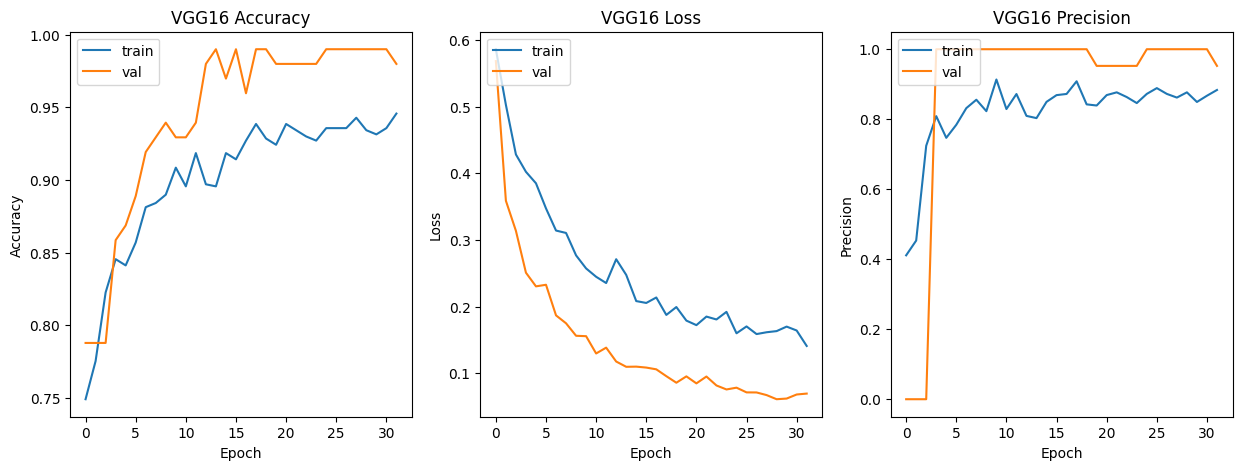

In [ ]:
plot_history(VGG16_history, 'VGG16')

ResNet50

In [ ]:
ResNet50_base = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in ResNet50_base.layers:
    layer.trainable = False

ResNet50=tf.keras.Sequential()
ResNet50.add(ResNet50_base)
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Flatten())
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dense(1,activation='sigmoid'))

ResNet50.summary()

ResNet50.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_10 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_8 (Bat  (None, 100352)            401408    
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 32)                3211296   
                                                                 
 batch_normalization_9 (Bat  (None, 32)                

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('ResNet50.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

ResNet50_history = ResNet50.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.7118 - Accuracy: 0.6437 - Precision: 0.3333 - Recall: 0.6546 - AUC: 0.7388 - F1: 0.3306

22/22 [==============================] - 22s 628ms/step - loss: 0.7118 - Accuracy: 0.6437 - Precision: 0.3333 - Recall: 0.6546 - AUC: 0.7388 - F1: 0.3306 - val_loss: 0.6043 - val_Accuracy: 0.7778 - val_Precision: 0.4000 - val_Recall: 0.0952 - val_AUC: 0.5962 - val_F1: 0.1125 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.5934 - Accuracy: 0.6795 - Precision: 0.3011 - Recall: 0.3733 - AUC: 0.6263 - F1: 0.3215

22/22 [==============================] - 12s 548ms/step - loss: 0.5934 - Accuracy: 0.6795 - Precision: 0.3011 - Recall: 0.3733 - AUC: 0.6263 - F1: 0.3215 - val_loss: 0.5579 - val_Accuracy: 0.8182 - val_Precision: 1.0000 - val_Recall: 0.1429 - val_AUC: 0.5266 - val_F1: 0.1750 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.5400 - Accuracy: 0.7582 - Precision: 0.4095 - Recall: 0.2867 - AUC: 0.6563 - F1: 0.3261

22/22 [==============================] - 12s 542ms/step - loss: 0.5400 - Accuracy: 0.7582 - Precision: 0.4095 - Recall: 0.2867 - AUC: 0.6563 - F1: 0.3261 - val_loss: 0.4012 - val_Accuracy: 0.8182 - val_Precision: 1.0000 - val_Recall: 0.1429 - val_AUC: 0.8706 - val_F1: 0.2381 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.5145 - Accuracy: 0.7754 - Precision: 0.4426 - Recall: 0.1800 - AUC: 0.6599 - F1: 0.2400

22/22 [==============================] - 13s 570ms/step - loss: 0.5145 - Accuracy: 0.7754 - Precision: 0.4426 - Recall: 0.1800 - AUC: 0.6599 - F1: 0.2400 - val_loss: 0.3243 - val_Accuracy: 0.8586 - val_Precision: 0.8182 - val_Recall: 0.4286 - val_AUC: 0.9270 - val_F1: 0.4054 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.4633 - Accuracy: 0.8097 - Precision: 0.6545 - Recall: 0.2400 - AUC: 0.7373 - F1: 0.3658

22/22 [==============================] - 11s 497ms/step - loss: 0.4633 - Accuracy: 0.8097 - Precision: 0.6545 - Recall: 0.2400 - AUC: 0.7373 - F1: 0.3658 - val_loss: 0.3034 - val_Accuracy: 0.8990 - val_Precision: 0.8667 - val_Recall: 0.6190 - val_AUC: 0.9396 - val_F1: 0.5354 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.4572 - Accuracy: 0.8054 - Precision: 0.6400 - Recall: 0.2133 - AUC: 0.7406 - F1: 0.3109

22/22 [==============================] - 12s 524ms/step - loss: 0.4572 - Accuracy: 0.8054 - Precision: 0.6400 - Recall: 0.2133 - AUC: 0.7406 - F1: 0.3109 - val_loss: 0.3217 - val_Accuracy: 0.8788 - val_Precision: 0.7647 - val_Recall: 0.6190 - val_AUC: 0.9316 - val_F1: 0.5042 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.4302 - Accuracy: 0.8097 - Precision: 0.6667 - Recall: 0.2267 - AUC: 0.7880 - F1: 0.3333

22/22 [==============================] - 12s 542ms/step - loss: 0.4302 - Accuracy: 0.8097 - Precision: 0.6667 - Recall: 0.2267 - AUC: 0.7880 - F1: 0.3333 - val_loss: 0.3103 - val_Accuracy: 0.8788 - val_Precision: 0.7647 - val_Recall: 0.6190 - val_AUC: 0.9176 - val_F1: 0.4591 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.4194 - Accuracy: 0.8183 - Precision: 0.6575 - Recall: 0.3200 - AUC: 0.8010 - F1: 0.4118

22/22 [==============================] - 12s 542ms/step - loss: 0.4194 - Accuracy: 0.8183 - Precision: 0.6575 - Recall: 0.3200 - AUC: 0.8010 - F1: 0.4118 - val_loss: 0.3032 - val_Accuracy: 0.8990 - val_Precision: 0.8667 - val_Recall: 0.6190 - val_AUC: 0.8858 - val_F1: 0.4815 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.4305 - Accuracy: 0.8140 - Precision: 0.6786 - Recall: 0.2533 - AUC: 0.7733 - F1: 0.3672

22/22 [==============================] - 12s 543ms/step - loss: 0.4305 - Accuracy: 0.8140 - Precision: 0.6786 - Recall: 0.2533 - AUC: 0.7733 - F1: 0.3672 - val_loss: 0.2804 - val_Accuracy: 0.8889 - val_Precision: 0.8125 - val_Recall: 0.6190 - val_AUC: 0.9167 - val_F1: 0.6404 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.3809 - Accuracy: 0.8441 - Precision: 0.7733 - Recall: 0.3867 - AUC: 0.8381 - F1: 0.4889

22/22 [==============================] - 12s 539ms/step - loss: 0.3809 - Accuracy: 0.8441 - Precision: 0.7733 - Recall: 0.3867 - AUC: 0.8381 - F1: 0.4889 - val_loss: 0.2658 - val_Accuracy: 0.8889 - val_Precision: 0.7778 - val_Recall: 0.6667 - val_AUC: 0.9228 - val_F1: 0.5272 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.3974 - Accuracy: 0.8340 - Precision: 0.7024 - Recall: 0.3933 - AUC: 0.8163 - F1: 0.5078

22/22 [==============================] - 12s 556ms/step - loss: 0.3974 - Accuracy: 0.8340 - Precision: 0.7024 - Recall: 0.3933 - AUC: 0.8163 - F1: 0.5078 - val_loss: 0.2752 - val_Accuracy: 0.8889 - val_Precision: 0.7500 - val_Recall: 0.7143 - val_AUC: 0.9356 - val_F1: 0.7513 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.3823 - Accuracy: 0.8326 - Precision: 0.7200 - Recall: 0.3600 - AUC: 0.8359 - F1: 0.4672

22/22 [==============================] - 12s 556ms/step - loss: 0.3823 - Accuracy: 0.8326 - Precision: 0.7200 - Recall: 0.3600 - AUC: 0.8359 - F1: 0.4672 - val_loss: 0.2617 - val_Accuracy: 0.8990 - val_Precision: 0.7619 - val_Recall: 0.7619 - val_AUC: 0.9389 - val_F1: 0.7333 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.3742 - Accuracy: 0.8255 - Precision: 0.6628 - Recall: 0.3800 - AUC: 0.8456 - F1: 0.4845

22/22 [==============================] - 11s 512ms/step - loss: 0.3742 - Accuracy: 0.8255 - Precision: 0.6628 - Recall: 0.3800 - AUC: 0.8456 - F1: 0.4845 - val_loss: 0.2567 - val_Accuracy: 0.8687 - val_Precision: 0.6818 - val_Recall: 0.7143 - val_AUC: 0.9496 - val_F1: 0.7536 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.3641 - Accuracy: 0.8455 - Precision: 0.7188 - Recall: 0.4600 - AUC: 0.8527 - F1: 0.5632

22/22 [==============================] - 12s 547ms/step - loss: 0.3641 - Accuracy: 0.8455 - Precision: 0.7188 - Recall: 0.4600 - AUC: 0.8527 - F1: 0.5632 - val_loss: 0.2570 - val_Accuracy: 0.8788 - val_Precision: 0.6957 - val_Recall: 0.7619 - val_AUC: 0.9466 - val_F1: 0.5476 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.3663 - Accuracy: 0.8512 - Precision: 0.7300 - Recall: 0.4867 - AUC: 0.8461 - F1: 0.5712

22/22 [==============================] - 12s 547ms/step - loss: 0.3663 - Accuracy: 0.8512 - Precision: 0.7300 - Recall: 0.4867 - AUC: 0.8461 - F1: 0.5712 - val_loss: 0.2302 - val_Accuracy: 0.8889 - val_Precision: 0.7083 - val_Recall: 0.8095 - val_AUC: 0.9628 - val_F1: 0.5325 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.3667 - Accuracy: 0.8455 - Precision: 0.7283 - Recall: 0.4467 - AUC: 0.8441 - F1: 0.5318

22/22 [==============================] - 12s 541ms/step - loss: 0.3667 - Accuracy: 0.8455 - Precision: 0.7283 - Recall: 0.4467 - AUC: 0.8441 - F1: 0.5318 - val_loss: 0.2797 - val_Accuracy: 0.8990 - val_Precision: 0.7200 - val_Recall: 0.8571 - val_AUC: 0.9505 - val_F1: 0.8331 - lr: 0.0010
Epoch 17/36
22/22 [==============================] - ETA: 0s - loss: 0.3625 - Accuracy: 0.8512 - Precision: 0.7674 - Recall: 0.4400 - AUC: 0.8532 - F1: 0.5614

22/22 [==============================] - 12s 554ms/step - loss: 0.3625 - Accuracy: 0.8512 - Precision: 0.7674 - Recall: 0.4400 - AUC: 0.8532 - F1: 0.5614 - val_loss: 0.2979 - val_Accuracy: 0.8687 - val_Precision: 0.6429 - val_Recall: 0.8571 - val_AUC: 0.9432 - val_F1: 0.5529 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - ETA: 0s - loss: 0.3347 - Accuracy: 0.8670 - Precision: 0.7938 - Recall: 0.5133 - AUC: 0.8772 - F1: 0.6228
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 12s 546ms/step - loss: 0.3347 - Accuracy: 0.8670 - Precision: 0.7938 - Recall: 0.5133 - AUC: 0.8772 - F1: 0.6228 - val_loss: 0.2500 - val_Accuracy: 0.9293 - val_Precision: 0.8182 - val_Recall: 0.8571 - val_AUC: 0.9518 - val_F1: 0.6253 - lr: 0.0010
Epoch 18: early stopping


In [ ]:
ResNet50_scores = ResNet50.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 2s 227ms/step - loss: 0.1919 - Accuracy: 0.9356 - Precision: 0.8163 - Recall: 0.9091 - AUC: 0.9797 - F1: 0.8340


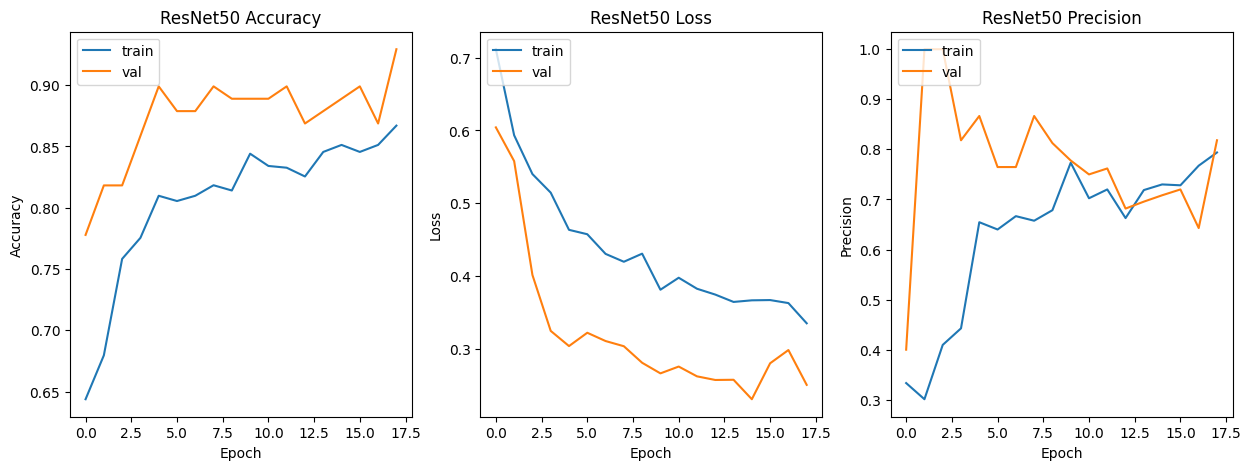

In [ ]:
plot_history(ResNet50_history, 'ResNet50')

In [ ]:
eval=[
    ('CNN', 0.3137 , 0.995 , 0.6377,1.0000 , 0.9827 , 0.7542),
    ('VGG16',0.0416, 0.995 , 0.9565, 1.0000, 0.9999 , 0.9832),
    ('ResNet50',0.1919 , 0.9356 , 0.8163 , 0.9091 , 0.9797 , 0.8340)
]

In [ ]:
import pandas as pd
#indices = ['CNN', 'VGG16', 'ResNet50']
indices = [item[0] for item in eval]
scores = pd.DataFrame({'Loss': [item[1] for item in eval],'Accuracy': [item[2] for item in eval], 'Precision': [item[3] for item in eval], 'Recall': [item[4] for item in eval], 'AUC': [item[5] for item in eval],'F1': [item[6] for item in eval]}, index=indices)
scores

,Loss,Accuracy,Precision,Recall,AUC,F1
CNN,0.3137,0.9950,0.6377,1.0000,0.9827,0.7542
VGG16,0.0416,0.9950,0.9565,1.0000,0.9999,0.9832
ResNet50,0.1919,0.9356,0.8163,0.9091,0.9797,0.8340


In [ ]:
import cv2
import numpy as np
import os

# Define the path to the folder containing image files
image_folder = '/content/drive/MyDrive/lung-cancer-detection-main/lung-cancer-detection-main/rawData'

# List to store image data
images = []

# Load and process each image in the folder
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg"):  # Assuming your images are in JPG format
        image_path = os.path.join(image_folder, filename)
        image = cv2.imread(image_path)  # Load the image
        images.append(image)

# Convert the list of images to a NumPy array
image_batch = np.array(images)

# Now you have your image batch ready for display


1/1 [==============================] - 0s 22ms/step


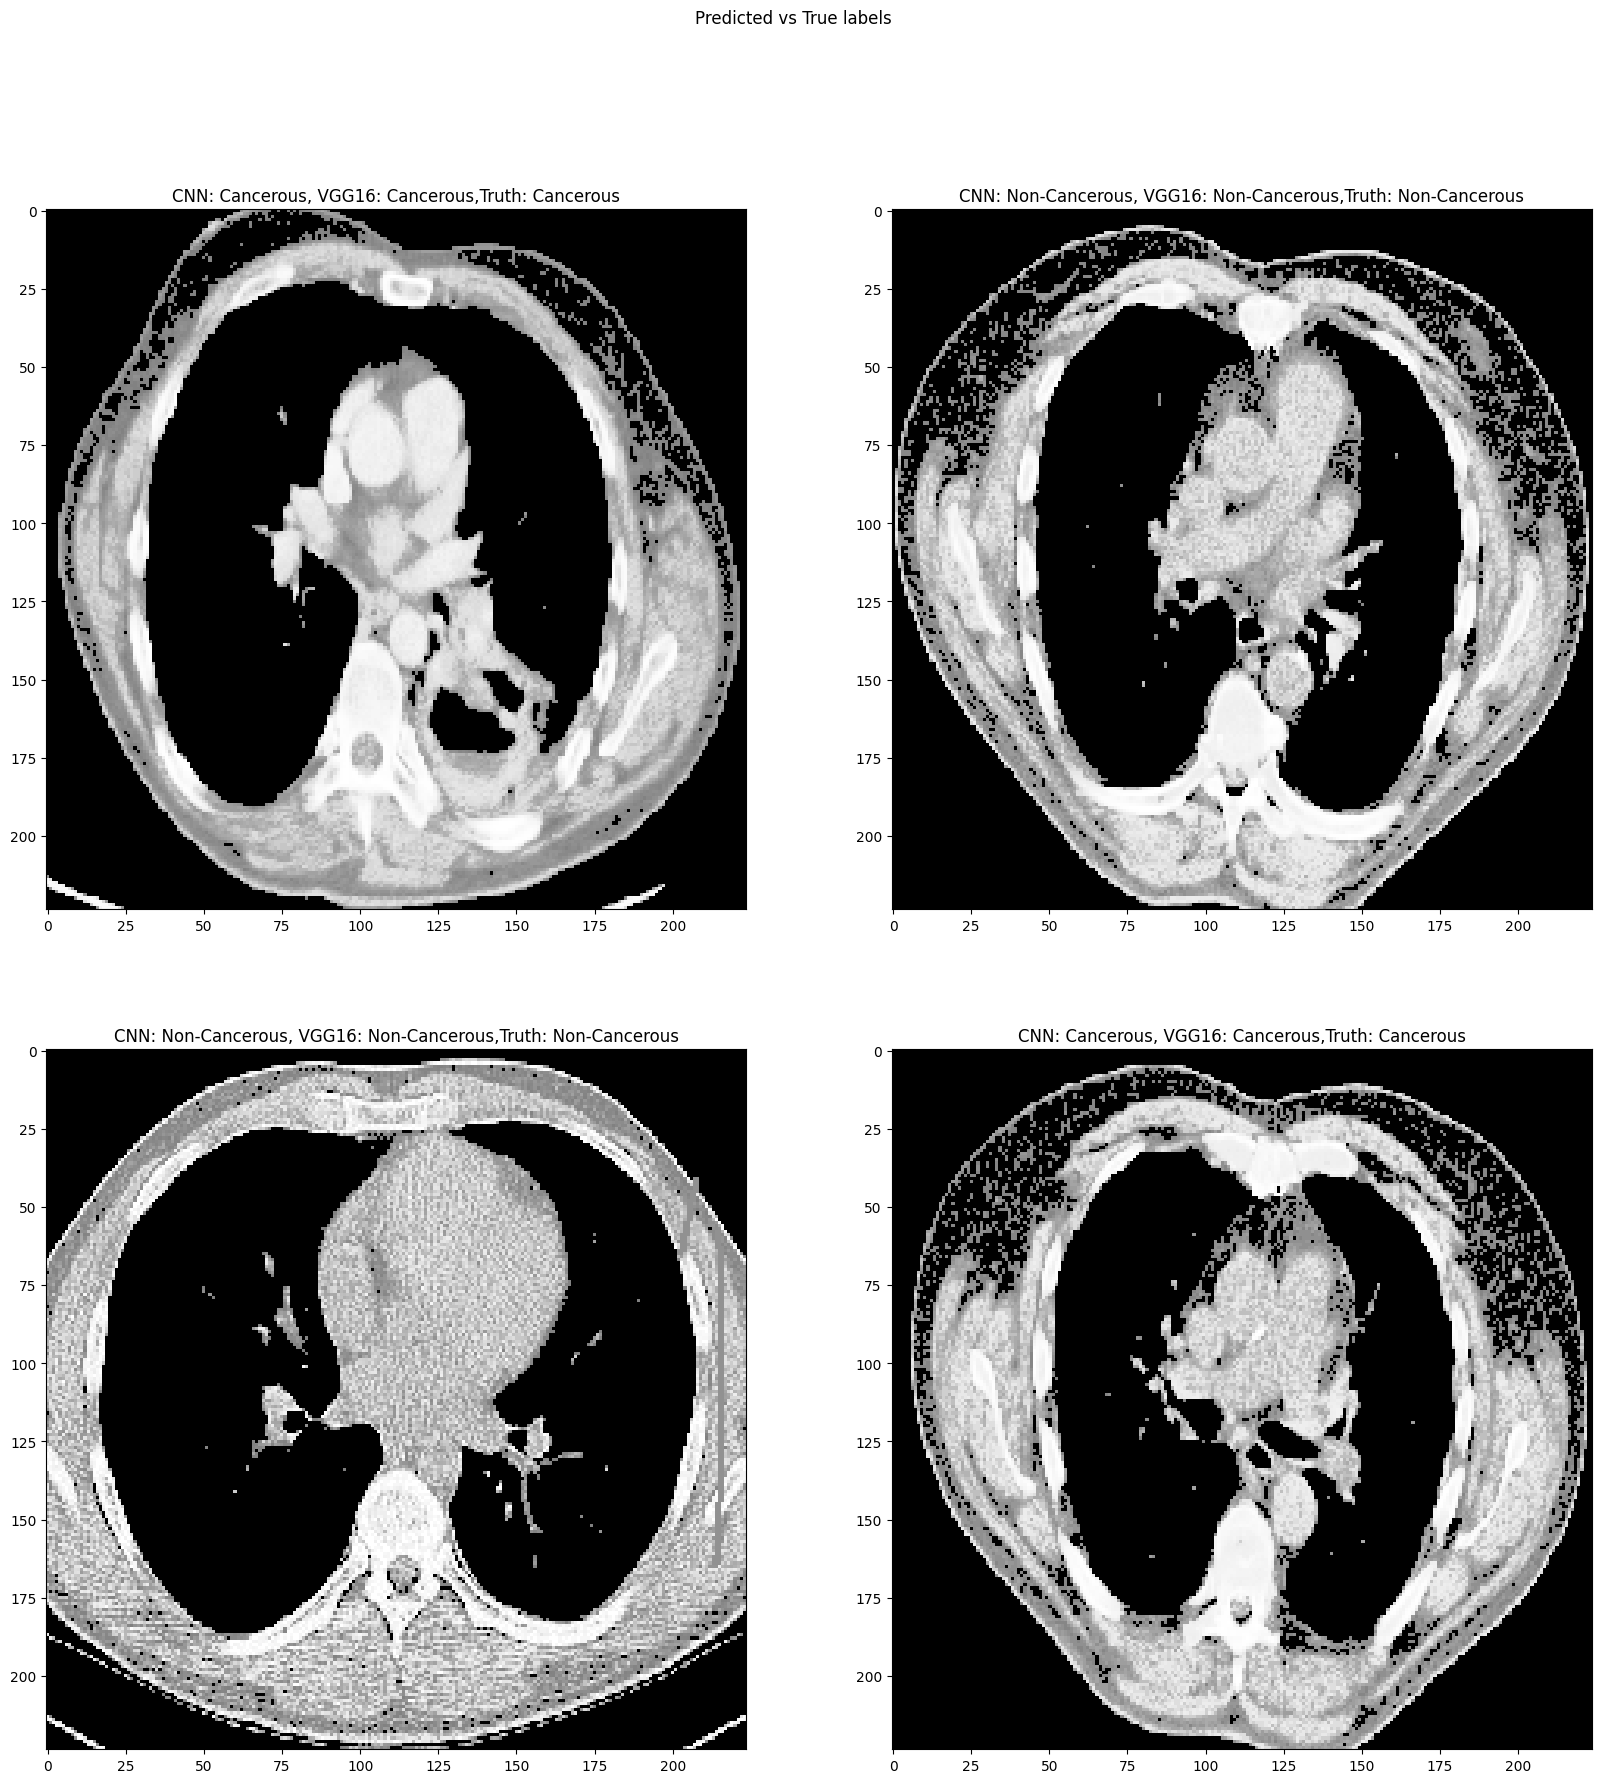

In [ ]:
batch = next(test_dataset)
def display_image_with_predictions(image, label, ax):
    resized_image = cv2.resize(image, (150, 150))  # Resize the image to the desired size
    ax.imshow(resized_image)
    ax.set_title(label)


def predAll(batch, i):
  label_dict = {0: 'Cancerous', 1: 'Non-Cancerous'}
  cnnPred = 0 if CNN.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  vgg16Pred = 0 if VGG16.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  # mobilenetPred = 0 if MOBILENET.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  # vgg19Pred = 0 if VGG19.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  # xceptionPred = 0 if Xception.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  # inceptionv3Pred = 0 if InceptionV3.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  resnet50Pred = 0 if ResNet50.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1

  return f'CNN: {label_dict[cnnPred]}, VGG16: {label_dict[vgg16Pred]},Truth: {label_dict[int(batch[1][i])]}'


plt.figure(figsize=(20, 20))

ax1 = plt.subplot(2, 2, 1)
plt.imshow(batch[0][0])
label = predAll(batch, 0)
ax1.set_title(label)


ax2 = plt.subplot(2, 2, 2)
plt.imshow(batch[0][5])
label = predAll(batch, 1)
ax2.set_title(label)

ax3 = plt.subplot(2, 2, 3)
plt.imshow(batch[0][2])
label = predAll(batch, 2)
ax3.set_title(label)

ax4 = plt.subplot(2, 2, 4)
plt.imshow(batch[0][3])
label = predAll(batch, 3)
ax4.set_title(label)


plt.suptitle('Predicted vs True labels')
plt.show()

SVM

Accuracy: 95.00%


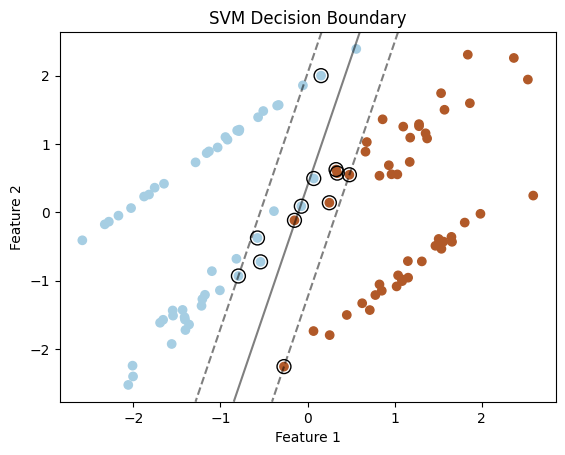

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate synthetic data with some overlap
X, y = datasets.make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=2, n_redundant=0, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plot the decision boundary
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

# Plot decision boundary and margins
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')
plt.title('SVM Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [ ]:
pip install scikit-learn


Confusion Matrix:
[[157   1]
 [  3  41]]


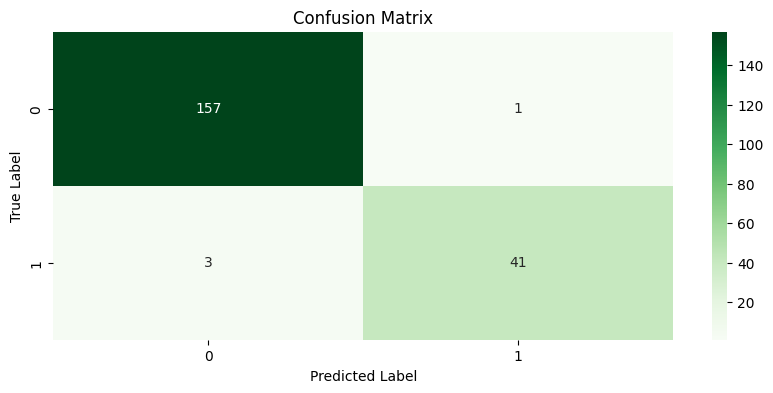

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Random Forest(Bagging)

Accuracy: 95.00%


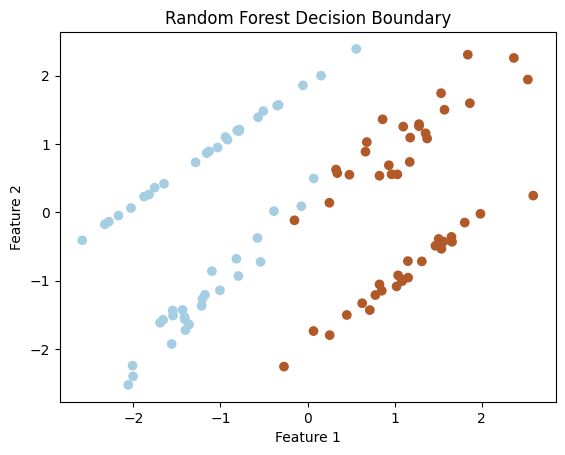

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate synthetic data with some overlap
X, y = datasets.make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=2, n_redundant=0, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plot the decision boundary (not applicable for Random Forest)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.title('Random Forest Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


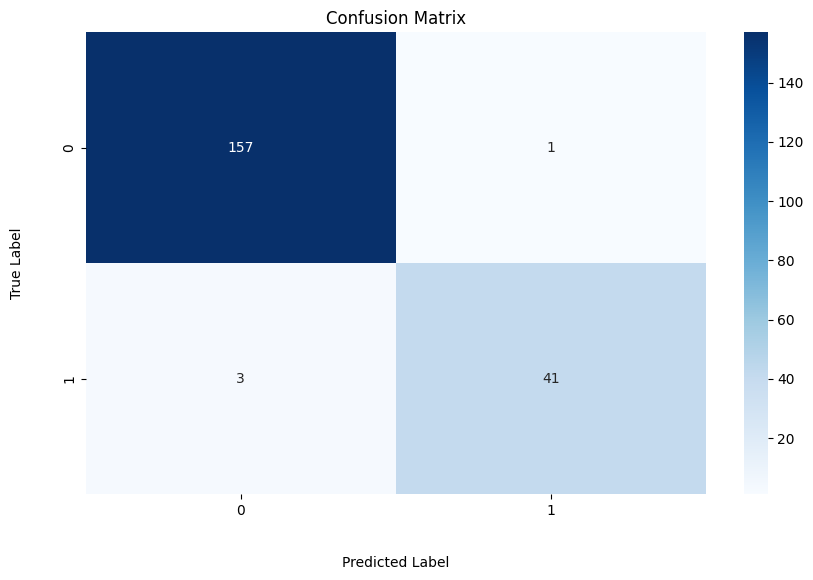

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('\n\nPredicted Label')
plt.ylabel('True Label\n\n')
plt.title('Confusion Matrix')
plt.show()


Boosting

Accuracy: 100.00%


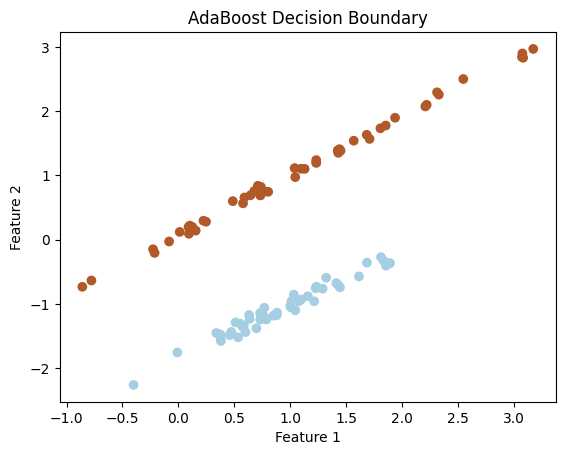

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate synthetic data with reduced complexity
X, y = datasets.make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, n_redundant=0, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree classifier (as the base estimator)
base_classifier = DecisionTreeClassifier(max_depth=1, random_state=42)

# Create an AdaBoost classifier with the Decision Tree as the base estimator
clf = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plot the decision boundary (not applicable for AdaBoost)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.title('AdaBoost Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


Accuracy: 95.00%


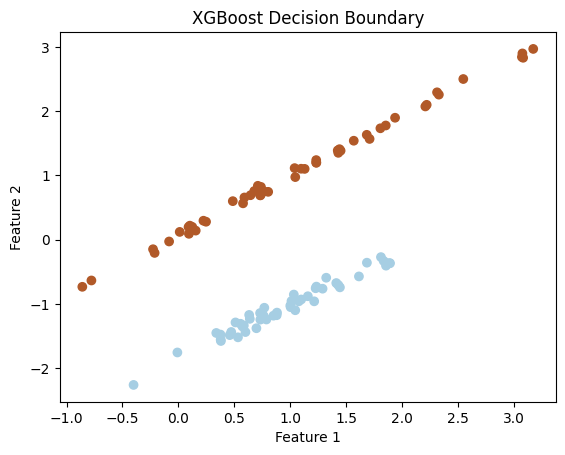

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Generate synthetic data with reduced complexity
X, y = datasets.make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, n_redundant=0, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost classifier
clf = xgb.XGBClassifier(n_estimators=50, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plot the decision boundary (not applicable for XGBoost)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.title('XGBoost Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


Hybridisation

Accuracy: 95.00%


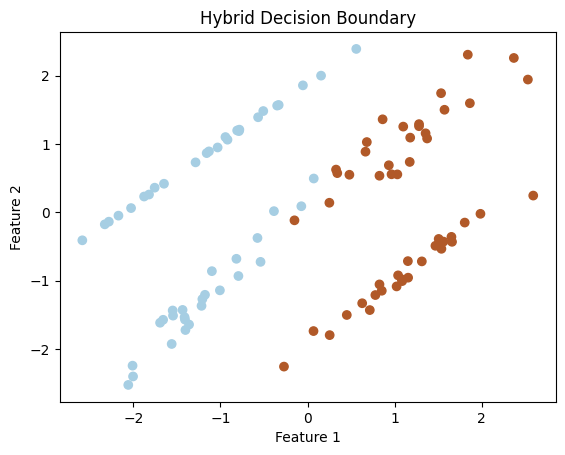

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate synthetic data with some overlap
X, y = datasets.make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=2, n_redundant=0, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create individual classifiers (Random Forest and SVM)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
svm_classifier = svm.SVC(kernel='linear', probability=True)  # Enable probability estimates

# Create a Voting Classifier that combines the classifiers
clf = VotingClassifier(estimators=[('rf', rf_classifier), ('svm', svm_classifier)], voting='soft')

# Train the ensemble classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plot the decision boundary (not applicable for ensemble)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.title('Hybrid Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Load a pre-trained ResNet-50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define the two input branches of the Siamese Network
input_shape = (224, 224, 3)
left_input = Input(shape=input_shape)
right_input = Input(shape=input_shape)

# Apply the same base ResNet model for both inputs
left_output = base_model(left_input)
right_output = base_model(right_input)

# Define the distance metric (Euclidean distance) between the outputs of the base networks
distance = Lambda(lambda x: tf.keras.backend.abs(x[0] - x[1]))([left_output, right_output])

# Create the Siamese Network model
siamese_model = Model(inputs=[left_input, right_input], outputs=distance)

# Unfreeze the base ResNet model for fine-tuning
base_model.trainable = True

# Compile the Siamese Network with a very low learning rate and binary cross-entropy loss
siamese_model.compile(optimizer=RMSprop(learning_rate=0.000001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Print the model summary
siamese_model.summary()

# Training the Siamese Network using your data generators
# history = .fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, workers=10, epochs=20)

history = siamese_model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, workers=10, epochs=20)

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_2[0][0]',             
                                                          2          'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             

NameError: ignored